### Alignment
In the NSMN paper, alignment is one of the key steps in the modelling. We will look at the details of textual entailment here.

In [20]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [55]:
!mkdir -p entailment/data

Download the glove embeddings and the SNLI dataset

In [61]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip

In [21]:
!ls entailment/data

__MACOSX  glove.6B.zip	snli_1.0  snli_1.0.bak.zip  snli_1.0.zip


#### Preparing the data

We will use golve embeddings to initialize the embeddings in our nerual network and also set it to non-trainable.

Load the glove embeddings into an embedding matrix, but first we need the tokens from our text.

Lets peek into a few lines in the training dataset. The training dataset .csv file is apprently quite large, so we will settle for the 'dev' .csv file.

In [884]:
import os
import zipfile
import io
import numpy as np
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'

counter = 0
columns = ['gold_label','sentence1','sentence2']
indices = [-1, -1, -1]
with zipfile.ZipFile(zip_file_name) as z:
    for info in z.infolist():
        if output_file_name in info.filename:
            # read the file
            print("Reading lines from file {}".format(output_file_name))
            with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                for line in f:
                    terms = line.split('\t')
                    if np.min(indices) == -1: # this is the first line
                        print("header line:")
                        print(line)
                        indices = [np.where(np.array(terms) == val)[0] for val in columns]
                    else:
                        print(line)
                        idx = [i[0] for i in indices]
                        print(np.array(terms)[idx])
                    counter += 1
                    if counter > 2:
                        break

Reading lines from file snli_1.0/snli_1.0_train.txt
header line:
gold_label	sentence1_binary_parse	sentence2_binary_parse	sentence1_parse	sentence2_parse	sentence1	sentence2	captionID	pairID	label1	label2	label3	label4	label5

neutral	( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) )	( ( A person ) ( ( is ( ( training ( his horse ) ) ( for ( a competition ) ) ) ) . ) )	(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .)))	(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))	A person on a horse jumps over a broken down airplane.	A person is training his horse for a competition.	3416050480.jpg#4	3416050480.jpg#4r1n	neutral				

['neutral' 'A person on a horse jumps over a broken down airplane.'
 'A person is training his horse for a competiti

##### The structure of the training records
As you can see from above, the dataset contains a label, the hypothesis sentence in 'sentence1' and the evidence sentence in 'sentence2', among several other values such as the parsed sentences as binary parsed as well as parsed with POS tagging.

The important fields for us are the gold_label, the sentence1 and sentence2.

We will need to write a parser to extract these into our training dataset.


- sentence1: The premise caption that was supplied to the author of the pair.

- sentence2: The hypothesis caption that was written by the author of the pair.

- sentence{1,2}_parse: The parse produced by the Stanford Parser (3.5.2, case insensitive PCFG, trained on the standard training set augmented with the parsed Brown Corpus) in Penn Treebank format.

- sentence{1,2}_binary_parse: The same parse as in sentence{1,2}_parse, but formatted for use in tree-structured neural networks with no unary nodes and no labels.

- annotator_labels (label1-5 in the tab separated file): These are all of the individual labels from annotators in phases 1 and 2. The first label comes from the phase 1 author, and is the only label for examples that did not undergo phase 2 annotation. In a few cases, the one of the phase 2 labels may be blank, indicating that an annotator saw the example but could not annotate it.

- gold_label: This is the label chosen by the majority of annotators. Where no majority exists, this is '-', and the pair should not be included when evaluating hard classification accuracy.

- captionID: A unique identifier for each sentence1 from the original Flickr30k example.

- pairID: A unique identifier for each sentence1--sentence2 pair.

*NOTE: captionID and pairID contain information that can be useful in making classification decisions and should not be included in model input (nor, of course, should either annotator_labels or gold_label).*




In [22]:
import os
import zipfile
import io
import numpy as np
from tqdm import tqdm
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'

def load_data(num_samples=10):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    data = []
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if output_file_name in info.filename:
                # read the file
                print("Reading lines from file {}".format(output_file_name))
                with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                    for line in tqdm(f):
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data.append(np.array(terms)[idx])
                                counter += 1
                        if (num_samples > -1) & (counter > num_samples):
                            return data

In [23]:
data = load_data(100000)
print("Read {} records".format(len(data)))

1213it [00:00, 12127.47it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


100111it [00:04, 20698.59it/s]


Read 100000 records


#### Prepare train and dev dataset
We will need to create the train and dev dataset splits. We need to ensure that each of the splits have sufficient number of samples for all labels.

In [24]:
def train_test_split(data, ratio=0.7):
    labels = [d[0] for d in data]
    u_labels = np.unique(labels)
    samples = {}
    for d in data:
        if d[0] in samples:
            samples[d[0]].append((d[1], d[2]))
        else:
            samples[d[0]] = [(d[1], d[2])]

    train = []
    dev = []

    for lbl in u_labels:
        num_samples = len(samples[lbl])
        idx = np.arange(num_samples)
        np.random.shuffle(idx)
        train.extend([(lbl, s1, s2) for s1, s2 in np.array(samples[lbl])[idx][:int(num_samples*ratio)]])
        dev.extend([(lbl, s1, s2) for s1, s2 in np.array(samples[lbl])[idx][int(num_samples*ratio):]])
    return train, dev

In [25]:
train, test = train_test_split(data, 0.7)

In [26]:
train[:3]

[('contradiction',
  'A white dog running in the backyard.',
  'The dog is sleeping.'),
 ('contradiction',
  'A man walking through town carrying his goods.',
  'A man sleeping on his couch.'),
 ('contradiction',
  'A boy in a green sweatshirt and blue jeans performs a trick on a skateboard while spectators in the background are looking on.',
  'The piano player finishes his piece of music.')]

#### Dataset preparation

We will need to convert the texts to sequences.

We will need to write a sentence preprocessor, one that processes each of the sentences.

In [27]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w

We will also need a tokenizer that will first fit to the entire corpus and then tokenize the texts.

The tokenizer needs to see the entire corpus, so we will need to merge the hypothesis and evidence for the tokenization task.
Using the tokenizer, we will also tokenize the sentences, the hypothesis and the evidences.

In [28]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [29]:
all_texts = [" ".join((preprocess(t[1]),preprocess(t[2]))) for t in train]
lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
lang_tokenizer.fit_on_texts(all_texts)
hyp_tokens = lang_tokenizer.texts_to_sequences([preprocess(t[1]) for t in train])
hyp_tokens = tf.keras.preprocessing.sequence.pad_sequences(hyp_tokens, padding='post')
evi_tokens = lang_tokenizer.texts_to_sequences([preprocess(t[2]) for t in train])
evi_tokens = tf.keras.preprocessing.sequence.pad_sequences(evi_tokens, padding='post')

In [30]:
print(evi_tokens[0])
print(evi_tokens[0].shape)
print(hyp_tokens[0].shape)
print(type(evi_tokens))
len(evi_tokens)
max_len_hyp = hyp_tokens[0].shape[0]
max_len_evi = evi_tokens[0].shape[0]
print("Max length of hypothesis = {} and evidence = {}".format(max_len_hyp, max_len_evi))

[  3   6  31   8 149   5   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
(46,)
(84,)
<class 'numpy.ndarray'>
Max length of hypothesis = 84 and evidence = 46


In [31]:
labels = [t[0] for t in train]

In [32]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)

In [33]:
train_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    train_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(train_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(train_labels)))

A peek a the reshaped labels:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [34]:
features = np.concatenate((hyp_tokens, evi_tokens), axis = 1)

In [35]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(features, train_labels, test_size=0.3)

In [36]:
print(input_tensor_train[:1])
print(input_tensor_train.shape)

[[   3    2   15  553   54   62    2  727    7    2 2295 8179  223    5
     4    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    2   15  867  727   54    7   21 8858    7    6  216   13    2
   599    5    4    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
(48999, 130)


In [37]:
target_tensor_train[:3]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

Our inputs are now encoded, so we will need to send in these encoded inputs to our network for training. 

What about golve embeddings?

The sequence tokens we have are word vectorized by vocabulary.

Some reference is [here](https://heartbeat.fritz.ai/text-classification-using-long-short-term-memory-glove-embeddings-6894abb730e1)

The lang tokenizer we used earlier already has the word index. We can use those to look up glove embeddings.

Let's read the glove embeddings.

In [543]:
lang_tokenizer.word_index

{'<OOV>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 '.': 5,
 'the': 6,
 'in': 7,
 'is': 8,
 'man': 9,
 'on': 10,
 'and': 11,
 'of': 12,
 'are': 13,
 'with': 14,
 ',': 15,
 'to': 16,
 'woman': 17,
 'two': 18,
 'people': 19,
 'his': 20,
 'at': 21,
 'an': 22,
 'young': 23,
 'black': 24,
 'shirt': 25,
 'playing': 26,
 'girl': 27,
 'while': 28,
 'men': 29,
 'boy': 30,
 'wearing': 31,
 'white': 32,
 'dog': 33,
 'her': 34,
 'sitting': 35,
 'red': 36,
 'outside': 37,
 'standing': 38,
 'blue': 39,
 'one': 40,
 'down': 41,
 'for': 42,
 'group': 43,
 'children': 44,
 'by': 45,
 'holding': 46,
 'street': 47,
 'walking': 48,
 'three': 49,
 'brown': 50,
 'women': 51,
 'person': 52,
 'other': 53,
 'as': 54,
 'green': 55,
 'there': 56,
 'dressed': 57,
 'their': 58,
 'front': 59,
 'next': 60,
 'water': 61,
 'into': 62,
 'that': 63,
 'looking': 64,
 'sidewalk': 65,
 'near': 66,
 'camera': 67,
 'little': 68,
 'background': 69,
 'it': 70,
 'doing': 71,
 'from': 72,
 'jumping': 73,
 'has': 74,
 'building': 

In [38]:
ls entailment/data

__MACOSX/  glove.6B.zip  snli_1.0/  snli_1.0.bak.zip  snli_1.0.zip


Loading the glove embeddings

In [39]:
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
Reading lines from file glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt


Let's analyze what we have in the tokenized sequences. A look at the first example, we have a label, the hypothesis and the evidence.

In [40]:
train[:1]

[('contradiction',
  'A white dog running in the backyard.',
  'The dog is sleeping.')]

The tokens for the above hypothesis 'Masked actors perform traditional Japanese theater.' is

In [41]:
print(hyp_tokens[:1].shape)
hyp_tokens[:1]

(1, 84)


array([[  3,   2,  28,  31,  70,   7,   6, 829,   5,   4,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]], dtype=int32)

The tokens are the indices of the words in the vocabublary of the tokenizer as seen below.

In [42]:
sent = 'A group of people clap and take pictures of an unseen subject .'
for word in sent.lower().split(' '):
    print("Index of word {} in the tokenized sequence is {}".format(word, lang_tokenizer.word_index.get(word)))

Index of word a in the tokenized sequence is 2
Index of word group in the tokenized sequence is 40
Index of word of in the tokenized sequence is 13
Index of word people in the tokenized sequence is 17
Index of word clap in the tokenized sequence is 4529
Index of word and in the tokenized sequence is 11
Index of word take in the tokenized sequence is 410
Index of word pictures in the tokenized sequence is 405
Index of word of in the tokenized sequence is 13
Index of word an in the tokenized sequence is 21
Index of word unseen in the tokenized sequence is 2185
Index of word subject in the tokenized sequence is 4913
Index of word . in the tokenized sequence is 5


If we are now using the glove embeddings, instead of using the indices of the words, we will be using the 50 dimensional word embedding for the word in the vocabulary. E.g. the embedding for 'masked' would be.

In [43]:
#print(lang_tokenizer.word_index)
embeddings_index.get('masked')

array([-1.0912e-01, -7.7150e-01,  5.8735e-01, -2.7371e-01,  1.2132e+00,
        1.0705e-01, -1.2723e-01,  2.5333e-02, -8.0314e-01, -2.0963e-02,
        2.6252e-01, -1.1936e+00, -3.6585e-01,  9.5928e-01, -8.6888e-02,
       -7.5409e-01, -3.2490e-01,  2.1727e-01, -1.1456e+00, -3.8625e-01,
       -2.4218e-01,  9.1697e-01,  1.9012e-01,  3.7527e-01, -7.4516e-01,
       -3.5927e-01, -5.2885e-01,  2.7933e-01,  5.4898e-02, -4.1675e-01,
        1.0453e+00, -6.1269e-04, -1.4485e-01, -2.5002e-01,  2.7415e-01,
        9.8532e-01, -1.2851e-01, -1.5922e+00, -5.0248e-01,  2.1163e-02,
       -1.4607e-01,  5.6129e-02, -2.9917e-01,  8.6975e-02,  1.1894e+00,
       -1.7840e+00, -5.7097e-02, -3.2755e-01,  7.1164e-01, -1.4130e+00],
      dtype=float32)

Let's create the embedding matrix which will serve as the look up for the embedding for the words. 

The keras embedding layer will look up the embedding when running our training.

In [44]:
embeddings_index["the"].shape
max_length = embeddings_index["the"].shape[0]
print("max length of sequence is {}".format(max_length))

max length of sequence is 50


In [45]:
max_length = 50
embedding_matrix = np.zeros((len(lang_tokenizer.word_index) + 1, max_length))
for word, i in lang_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

The index of 'masked' was 567, the embedding for it is

In [46]:
embedding_matrix[567]

array([-0.11941   ,  0.41365001, -0.069033  , -0.7823    ,  0.71780002,
        1.39260006, -0.42550001, -0.97036999,  1.0668    ,  0.29361001,
        0.42355999, -0.26536   ,  1.2586    ,  0.58969998,  0.66358   ,
       -0.11947   , -0.54562998,  0.63848001, -0.33372   ,  0.16693   ,
       -0.24625   ,  0.70568001,  1.18280005,  1.50090003, -0.23576   ,
       -0.65605003, -0.25080001, -0.62052   ,  0.092142  ,  0.018576  ,
        2.62179995,  0.23755001,  0.20074999, -0.92991   ,  0.14143001,
        0.26080999,  0.22187001, -0.55680001, -0.34384   , -1.00489998,
       -0.15775   , -0.31162   ,  0.18086   ,  0.97092003,  0.31748   ,
       -0.29818001,  0.24237999, -0.78579003, -0.48475   ,  0.92211998])

In [47]:
embedding_matrix.shape

(14864, 50)

#### Network options

At first, we will not use the embedding layer, instead we will send in the tokens as is into our network.

Let us prepare the network.

From the references  [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn) we build the network.

Note, we will not send any embeddin matrix here, in fact we will let the network learn the embeddings.

The embedding layer, when called, converts the sequences of word indices to sequences of vectors.

In [48]:
# embedding_layer = Embedding(len(word_index),
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)
# sequence_input = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)
# print(embedded_sequences)
# x1 = Conv1D(filters, kernel_size, padding='valid', activation='tanh')(embedded_sequences)
# x2 = keras.layers.GlobalMaxPooling1D()(x1)
# model = keras.Model(sequence_input, x2)
# model.summary()

In [49]:
len(lang_tokenizer.word_index)

14863

#### Build the network

In [51]:
from tensorflow import keras

In [53]:
print(keras.__version__)

2.4.0


In [54]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
inp = keras.Input(shape=(None,))
x1 = embedding_layer(inp)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x1)
x3 = tf.keras.layers.Dense(16, activation='relu')(x2)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model = keras.Model(inp, output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 50)          743200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 785,267
Trainable params: 42,067
Non-trainable params: 743,200
________________________________________________

### Alternate embedding layer with glove network 
`embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)`

In [794]:
# vocab_size = len(lang_tokenizer.word_index)
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(3)
# ])

# model.summary()

In [55]:
train[:1]

[('contradiction',
  'A white dog running in the backyard.',
  'The dog is sleeping.')]

In [987]:
# s = 'Masked actors perform traditional Japanese theater.'
# print(s)
# s = preprocess(s)
# print(s)
# s_toks = lang_tokenizer.texts_to_sequences([s])
# s_toks = tf.keras.preprocessing.sequence.pad_sequences(s_toks, padding='post')
# s_toks

In [989]:
# l, h, e = train[:1][0]
# h = preprocess(h)
# h_toks = lang_tokenizer.texts_to_sequences([h])
# h_toks = tf.keras.preprocessing.sequence.pad_sequences(h_toks, maxlen=max_len_hyp, padding='post')
# e = preprocess(e)
# e_toks = lang_tokenizer.texts_to_sequences([e])
# e_toks = tf.keras.preprocessing.sequence.pad_sequences(e_toks, maxlen=max_len_evi, padding='post')

In [990]:
# print(h_toks.shape)
# h_toks

In [991]:
# e_toks[0].shape

In [992]:
# np.concatenate((h_toks, e_toks), axis = 1).shape

In [995]:
#sample_text = ('The movie was cool. The animation and the graphics '
             #  'were out of this world. I would recommend this movie.')
# predictions = model.predict(np.concatenate((h_toks, e_toks), axis = 1))
# print(predictions[0])

In [996]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [56]:
!rm -rf tmp/checkpoint
!mkdir -p tmp

In [57]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [58]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [59]:
for example, label in train_dataset.take(1):
    print(example.shape)
    print(example)
    print(label.shape)

(64, 130)
tf.Tensor(
[[ 3  2  9 ...  0  0  0]
 [ 3  2 26 ...  0  0  0]
 [ 3 16 82 ...  0  0  0]
 ...
 [ 3  2 26 ...  0  0  0]
 [ 3  2 15 ...  0  0  0]
 [ 3  2 15 ...  0  0  0]], shape=(64, 130), dtype=int32)
(64, 3)


In [60]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

As the val loss starts increasing for certain number of iterations, the training will stop and we would need to go back to the bext model for which the loss was the least. Therefore, we would need to checkpoint the model weights to a file.

In [61]:
history = model.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
765/765 [==============================] - 70s 85ms/step - loss: 1.0475 - accuracy: 0.4424 - val_loss: 0.9365 - val_accuracy: 0.5536
Epoch 2/20
765/765 [==============================] - 66s 85ms/step - loss: 0.9348 - accuracy: 0.5512 - val_loss: 0.8854 - val_accuracy: 0.5880
Epoch 3/20
765/765 [==============================] - 57s 75ms/step - loss: 0.8935 - accuracy: 0.5799 - val_loss: 0.8522 - val_accuracy: 0.6089
Epoch 4/20
765/765 [==============================] - 61s 80ms/step - loss: 0.8617 - accuracy: 0.6056 - val_loss: 0.8294 - val_accuracy: 0.6339
Epoch 5/20
765/765 [==============================] - 61s 80ms/step - loss: 0.8361 - accuracy: 0.6255 - val_loss: 0.8130 - val_accuracy: 0.6411
Epoch 6/20
765/765 [==============================] - 63s 82ms/step - loss: 0.8143 - accuracy: 0.6380 - val_loss: 0.8175 - val_accuracy: 0.6375
Epoch 7/20
765/765 [==============================] - 65s 84ms/step - loss: 0.7983 - accuracy: 0.6453 - val_loss: 0.8053 - val_accuracy:

Text(0.5, 1.0, 'Metrics for training SNLI dataset, 70K samples (glove)')

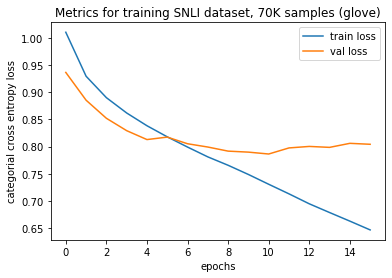

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training SNLI dataset, 70K samples (glove)")
#history.history['loss']

In [63]:
model.load_weights(checkpoint_filepath)

In [64]:
model.evaluate(val_dataset)

328/328 [==============================] - 11s 32ms/step - loss: 0.8351 - accuracy: 0.6413


[0.8350659608840942, 0.6412919163703918]

#### Summary

loss: 0.8276 - accuracy: 0.6454

### Language translation


Now let's take a look at how the data preparation is done in case of sequence to sequence models in tensorflow.

We will look at the example of machine translation.

We will use the code from [networks_seq2seq_nmt](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) from tensorflow

First some imports.

In [375]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In language translations, the input format is as follows, where the translations are separated by a tab.

The lines are read in unicode, we will need to convert them to ascii after the split.

In [367]:
lines = ["May I borrow this book?\t¿Puedo tomar prestado este libro?",
         "May I borrow this bookish?\t¿Puedo tomar prestado este libromacho"]

In [368]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

        w = w.strip()

        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w

In [369]:
word_pairs = [[preprocess(w) for w in l.split('\t')] for l in lines]

In [370]:
tar_lang , inp_lang = zip(*word_pairs)

In [371]:
inp_lang

('<start> ¿ puedo tomar prestado este libro ? <end>',
 '<start> ¿ puedo tomar prestado este libromacho <end>')

In [372]:
def tokenize(lang):
        # lang = list of sentences in a language

        # print(len(lang), "example sentence: {}".format(lang[0]))
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
        lang_tokenizer.fit_on_texts(lang)

        ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
        ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
        tensor = lang_tokenizer.texts_to_sequences(lang) 

        ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
        ## and pads the sequences to match the longest sequences in the given input
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, lang_tokenizer

In [373]:
tokenize(tar_lang)

(array([[ 2,  3,  4,  5,  6,  9,  7,  8],
        [ 2,  3,  4,  5,  6, 10,  7,  8]], dtype=int32),
 <keras_preprocessing.text.Tokenizer at 0x7fcd821d7760>)

In [382]:
def download_nmt():
    path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file

In [383]:
download_nmt()

'/root/.keras/datasets/spa-eng/spa.txt'

##### Load the NMT dataset

In [399]:
path = '/root/.keras/datasets/spa-eng/spa.txt'
lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
n_samples = 1000
word_pairs = [[preprocess(w) for w in l.split('\t')] for l in lines[:n_samples]]
tar_lang , inp_lang = zip(*word_pairs)

In [400]:
tar_tensor, tar_toknz = tokenize(tar_lang)

In [401]:
inp_tensor, inp_toknz = tokenize(inp_lang)

In [404]:
print("Tensor shapes, target = {}, input = {}".format(tar_tensor.shape, inp_tensor.shape))

Tensor shapes, target = (1000, 7), input = (1000, 9)


In [407]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [412]:
inp_ex, tar_ex = next(iter(train_dataset))

In [477]:
inp_ex[0]
tar_ex[0]

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([  2,   5,   9, 123,   4,   3,   0], dtype=int32)>

In [420]:
vocab_inp_size = len(inp_toknz.word_index)+1
vocab_tar_size = len(tar_toknz.word_index)+1
max_length_input = inp_ex.shape[1]
max_length_output = tar_ex.shape[1]

embedding_dim = 256
units = 1024
steps_per_epoch = n_samples//BATCH_SIZE
print("Input vocab size = {}, Target vocab size = {}".format(vocab_inp_size, vocab_tar_size))
print("Max input length = {}, max output length = {}".format(max_length_input, max_length_output))
print("Steps per epoch = {}".format(steps_per_epoch))

Input vocab size = 823, Target vocab size = 374
Max input length = 9, max output length = 7
Steps per epoch = 15


See a text classification example [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn) 

In [481]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_inp_size,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          52672     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 127,041
Trainable params: 127,041
Non-trainable params: 0
_________________________________________________________________


In [482]:
text_to_predict = "How are you?"
tensor = inp_toknz.texts_to_sequences(text_to_predict) 
## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
## and pads the sequences to match the longest sequences in the given input
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
tensor

array([[ 1],
       [ 1],
       [ 1],
       [ 0],
       [ 6],
       [ 1],
       [ 1],
       [ 0],
       [94],
       [ 1],
       [ 1],
       [ 9]], dtype=int32)

In [483]:
predictions = model.predict(tensor)
print(predictions[0])

[-0.00504636]


Create the embedding layer. The embedding layer needs the vocab size and the chosen embedding dimension.

In [425]:
embedding = tf.keras.layers.Embedding(vocab_inp_size, embedding_dim)

In [432]:
rnn_size = 64
rnn = tf.keras.layers.LSTMCell(rnn_size)
rnn

In [476]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
N = 30
l_h = 9
l_e = 8
D = 300
l_seq = l_h + l_e
vector_size=50
hyp = tf.Variable(tf.ones(shape=[N, l_h, D]), dtype=tf.float32)
evi = tf.Variable(tf.ones(shape=[N, l_e, D]), dtype=tf.float32)
x = tf.concat([hyp, evi], 1)
print(x.shape)
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
print(x.shape)
x = tf.reshape(x, [-1, vector_size])
print(x.shape)
# # Reshaping to (n_steps*batch_size, n_input)
# x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)
print(len(x))
print(x[0].shape)

(30, 17, 300)
(17, 30, 300)
(3060, 50)
17
(180, 50)
